He HUANG/LI M2/22107447

Copy this notebook (File>Save a copy in Drive) and then work on your copy.
==
To send me your work: use the sharing menu (top-right of the window) to share it with timothee.m.r.bernard@gmail.com.
(I don't check this address very often, so, for questions, please use Moodle or my u-paris.fr address.)


Goal
==
We are about to train a *sequence-to-sequence model* to predict a paragraph of Gustave Flaubert's *Madame Bovary* given the preceding paragraph.
The model (at least in its first version) does not use words as units of text but characters.

*   The encoder part, based on a bidirectional LSTM, reads an input paragraph and turns it into a set of tensors that serves as initial state for the decoder part.
*   The decoder part is based on an (unidirectional) LSTM. The state of the LSTM is used to compute a probability distribution over the alphabet (including space and punctuation marks) and is updated each time a character is predicted by the LSTM reading this character's embedding.
*   The goal is to get the best model. It is part of the job to define what this means. It is also part of the job to explain me how you get your best model.

This is an assignment.
==

*   Work in groups of two or three students.
*   Due date: December 4th (Monday), 23:59
*   Malus: -1 per day of delay.

Loading PyTorch is important.
==

In [ ]:
# Imports PyTorch.
import torch

Remarks:
==
*   Follow the instructions very carefully. Do not ignore any comment.
*   Keep in mind all remarks given in previous TPs.
*   Comment your code (including the role of all functions and the type of their arguments). A piece of code not appropriately commented can be considered incorrect (irrespectively of whether it works or not).
*   Indicate the shape of each tensor that you define.
*   Document all the changes that you make. Any work that is not properly explained can be ignored.

Downloading the dataset
==
The dataset we are going to use is there: "https://www.gutenberg.org/cache/epub/14155/pg14155.txt"

We have to pre-process it a little bit in order to remove everything that is not part of the text and to split the actual text into paragraphs.

In [ ]:
use_toy_dataset = False # If True, a toy dataset (see below) is use instead of the real one.

In [ ]:
# Downloads the dataset.
import urllib

tmp_book1 = urllib.request.urlretrieve("https://www.gutenberg.org/cache/epub/14155/pg14155.txt")
# Add second book url
tmp_book2 = urllib.request.urlretrieve("https://www.gutenberg.org/files/49773/49773-0.txt")
filename = tmp_book1[0]
print(filename)

/tmp/tmp6ah31etx


In [ ]:
# Prints the first 200 lines in the file with their line number.
# This shows that we have a little bit of preprocessing to do in order to clean the data.
with open(filename) as f:
  for i in range(200):
    print(f"[{i}] {f.readline()}", end='')

[0] ﻿The Project Gutenberg eBook of Madame Bovary
[1]     
[2] This ebook is for the use of anyone anywhere in the United States and
[3] most other parts of the world at no cost and with almost no restrictions
[4] whatsoever. You may copy it, give it away or re-use it under the terms
[5] of the Project Gutenberg License included with this ebook or online
[6] at www.gutenberg.org. If you are not located in the United States,
[7] you will have to check the laws of the country where you are located
[8] before using this eBook.
[9] 
[10] Title: Madame Bovary
[11] 
[12] 
[13] Author: Gustave Flaubert
[14] 
[15] Release date: November 26, 2004 [eBook #14155]
[16]                 Most recently updated: December 18, 2020
[17] 
[18] Language: French
[19] 
[20] 
[21] 
[22] *** START OF THE PROJECT GUTENBERG EBOOK MADAME BOVARY ***
[23] 
[24] 
[25] 
[26] Produced by Ebooks libres et gratuits at http://www.ebooksgratuits.com
[27] 
[28] 
[29] 
[30] 
[31] 
[32] Gustave Flaubert
[33] MADAME BOVARY
[3

In [ ]:
import re # Regular expression library
roman_regex = re.compile('^M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$') # This regular expression matches Roman numerals but also the empty string.

EOP = '\n' # The end-of-line character will be used to mark the end of paragraphs.
start = ["PREMIÈRE PARTIE", "L'ÉDUCATION SENTIMENTALE"]
def read_file(filename, encoding="utf-8"):
  with open(filename) as f:
  # We want to skip everything before the actual text of the novel.
  # The line "PREMIÈRE PARTIE" appears twice: in the table of content and then at the start of the first part of the actual text.
  # The following lines discard everything up to this second occurence (included).
    skip = 2
    while(skip > 0):
      line = f.readline().strip()
      if(line in start): skip -= 1;

    paragraphs = [] # Note that each dialog line will be considered a separate paragraph.
    paragraph_buffer = [] # List[str]; each element corresponds to a line in the original text file + an additonal space if necessary.
    while(True):
      line = f.readline().strip()
      if("END OF THE PROJECT GUTENBERG EBOOK" in line) or ("FIN DU PREMIER VOLUME." in line): break # End of the actual text.

      if(line == ""): # We've reached the end of a paragraph.
        if(len(paragraph_buffer) > 0):
           paragraph_buffer.append(EOP) # End of the paragraph.

           paragraph = "".join(paragraph_buffer) # The different lines that make up the paragraph are joined into a single string.
           paragraphs.append(paragraph)
           paragraph_buffer = []
        continue

      if(roman_regex.match(line)): continue # Ignores the lines that indicate the beginning of a chapter.
      if(line.endswith(" PARTIE")): continue # Ignores the lines that indicate the beginning of a part.

      if((len(paragraph_buffer) > 0) and (paragraph_buffer[-1][-1] != '-')): paragraph_buffer.append(' ') # Adds a space between consecutive lines except when the first one ends with "-" (e.g. if the word "pomme-de-terre" is split with "pomme-de-" at the end of a line and "terre" at the beginning of the next, we do not want to join the two lines with a space).
      paragraph_buffer.append(line)

  return paragraphs

In [ ]:
paragraphs = read_file(tmp_book1[0])+read_file(tmp_book2[0])
print(f"{len(paragraphs)} paragraphs read.")
for i in range(3): print(paragraphs[i], end='')

5217 paragraphs read.
Nous étions à l'Étude, quand le Proviseur entra, suivi d'un nouveau habillé en bourgeois et d'un garçon de classe qui portait un grand pupitre. Ceux qui dormaient se réveillèrent, et chacun se leva comme surpris dans son travail.
Le Proviseur nous fit signe de nous rasseoir; puis, se tournant vers le maître d'études:
-- Monsieur Roger, lui dit-il à demi-voix, voici un élève que je vous recommande, il entre en cinquième. Si son travail et sa conduite sont méritoires, il passera dans les grands, où l'appelle son âge.


Here, we define a toy dataset on which your model, if correctly implemented, should be able to learn more easily.

In [ ]:
if(use_toy_dataset):
  paragraphs = []

  import random, string
  characters = list(string.ascii_lowercase + string.ascii_lowercase.upper() + "_-/\'[]()")
  random.shuffle(characters)
  k = random.randint(1, 10)
  a = "a"
  paragraph = (a * k)
  for _ in range(100):
    random.shuffle(characters)
    for a in characters:
      k = random.randint(1, 16)
      paragraph += f"? Now, please write {k} {a}.{EOP}"
      paragraphs.append(paragraph)
      paragraph = (a * k)
  print(f"{len(paragraphs)} paragraphs generated.")

  print(paragraphs[:10])

In [ ]:
import collections
import numpy as np

# Computes the frequency of all characters in the dataset.
char_counts = collections.defaultdict(int)
for paragraph in paragraphs:
  for char in paragraph: char_counts[char] += 1

print(f"{len(char_counts)} different characters found in the dataset.")
print(sorted(char_counts.items(), key=(lambda x: x[1]), reverse=True)) # Shows each character with its frequency, in decreasing frequency order.

98 different characters found in the dataset.
[(' ', 172858), ('e', 121142), ('a', 71315), ('s', 68599), ('t', 61922), ('i', 61831), ('n', 57532), ('r', 56205), ('u', 52864), ('l', 52309), ('o', 43601), ('d', 31211), ('c', 23880), ('m', 23010), ('p', 21714), (',', 19660), ('é', 14123), ('v', 13197), ("'", 11668), ('.', 9906), ('b', 8931), ('f', 8650), ('h', 8304), ('q', 8111), ('g', 7648), ('-', 5877), ('\n', 5217), ('à', 4146), ('x', 3669), ('è', 2740), ('j', 2720), ('!', 2676), ('y', 2437), (';', 2420), ('E', 2025), ('ê', 1828), ('L', 1534), ('M', 1528), ('C', 1477), ('I', 1413), ('A', 1386), ('z', 1183), ('?', 952), ('«', 831), ('D', 829), (':', 822), ('»', 811), ('P', 798), ('ç', 769), ('â', 648), ('F', 630), ('S', 581), ('B', 547), ('R', 529), ('î', 522), ('O', 503), ('ô', 469), ('ù', 416), ('J', 395), ('Q', 381), ('H', 373), ('T', 366), ('V', 349), ('û', 340), ('N', 270), ('U', 264), ('_', 222), ('G', 105), ('œ', 96), ('(', 84), (')', 84), ('À', 84), ('Y', 83), ('É', 62), ('ï', 6

In [ ]:
# Here you have to build a dictionary 'char_vocabulary' that assigns an integer id to each character, along with a list/array 'id_to_char' that implements the reverse mapping.
#################
id_to_char = list({char for paragraph in paragraphs for char in paragraph})
char_vocabulary = {char: i for i, char in enumerate(id_to_char)}
#################

In [ ]:
EOP_id = char_vocabulary[EOP] # Id for the end-of-paragraph symbol

print(char_vocabulary)
print(id_to_char)
print(f"EOP_id = {EOP_id}")

# Here you have to implement a test that proves that your implementations of 'char_vocabulary' and 'id_to_char' are consistent.
#################
# Test : Check if every character in id_to_char is mapped to an id in char_vocabulary.
for i in range(len(id_to_char)):
    assert(char_vocabulary[id_to_char[i]] == i)
#################

{'6': 0, '4': 1, '?': 2, 'm': 3, '.': 4, 'G': 5, 'Î': 6, 'â': 7, ':': 8, '-': 9, 'ü': 10, 'b': 11, 'k': 12, '«': 13, 'n': 14, 'v': 15, 'j': 16, 'M': 17, 'æ': 18, 'L': 19, 'V': 20, 'g': 21, "'": 22, 'î': 23, 'R': 24, 'E': 25, ';': 26, '!': 27, ',': 28, '2': 29, 'W': 30, 'A': 31, 'À': 32, 'é': 33, 'h': 34, 'œ': 35, 'q': 36, 'p': 37, 'r': 38, 'y': 39, 'B': 40, 'Ç': 41, '»': 42, 'Ê': 43, '\n': 44, '3': 45, 'x': 46, 'H': 47, 'à': 48, 'l': 49, 'F': 50, 'Q': 51, '1': 52, '_': 53, 'S': 54, 'ë': 55, 'd': 56, 'ê': 57, 'o': 58, 'T': 59, ' ': 60, '7': 61, 'û': 62, 'ù': 63, '8': 64, 'J': 65, 'D': 66, 'X': 67, 'O': 68, 'U': 69, 'c': 70, 'ô': 71, 'u': 72, '5': 73, 's': 74, 'è': 75, 'É': 76, 'w': 77, 'e': 78, '0': 79, 'C': 80, ')': 81, 'z': 82, '(': 83, 'f': 84, 'ï': 85, 'I': 86, 'a': 87, '°': 88, 't': 89, 'N': 90, 'Y': 91, '9': 92, 'Ï': 93, 'Z': 94, 'i': 95, 'ç': 96, 'P': 97}
['6', '4', '?', 'm', '.', 'G', 'Î', 'â', ':', '-', 'ü', 'b', 'k', '«', 'n', 'v', 'j', 'M', 'æ', 'L', 'V', 'g', "'", 'î', 'R', 

In [ ]:
# Turns a list of lists of ids into a list of strings.
# Do not forget that an occurrence of EOP means that the paragraph ends here.
def ids_to_texts(ids, char_decoding_map, end_token_id):
  # Here you have to turn each list of character ids of 'ids' into a string and then return all strings as a list.
  #################
  decoded_texts = []
  separator = ''
  for sequence in ids:
    # convert sequence to list if it's a tensor
    if isinstance(sequence, torch.Tensor):
        sequence = sequence.tolist()
    # truncate the sequence at the end token if it's present
    try:
        end_token_index = sequence.index(end_token_id)
        sequence = sequence[:end_token_index]
    except ValueError:
     # If end_token_id is not in the sequence, use the entire sequence
        pass

     # convert each token ID to its corresponding string and join them
    decoded_sequence = separator.join([char_decoding_map[id] for id in sequence])
    decoded_texts.append(decoded_sequence)
  return decoded_texts
  #################

In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
print(ids)
print(ids_to_texts(ids, id_to_char, EOP_id))
print(f"'ids_to_texts(ids, id_to_char, EOP_id) == ps' should be True: {ids_to_texts(ids, id_to_char, EOP_id) == ps}")

[[40, 58, 14, 16, 58, 72, 38, 4], [80, 58, 3, 3, 78, 14, 89, 60, 87, 49, 49, 78, 82, 60, 15, 58, 72, 74, 60, 2]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids, id_to_char, EOP_id) == ps' should be True: True


In [ ]:
ps = ["Bonjour.", "Comment allez vous ?"]
ids = [[char_vocabulary[c] for c in p] for p in ps]
ids[0].extend([EOP_id, (EOP_id+1), (EOP_id+1)]) # With the end-of-paragraph token id and additional (padding-like) stuff for the first string.
print(ids)
print(ids_to_texts(ids, id_to_char, EOP_id))
print(f"'ids_to_texts(ids, id_to_char, EOP_id) == ps' should be True: {ids_to_texts(ids, id_to_char, EOP_id) == ps}") # If you have a problem here, remember that EOP indicates the end of the text (this might be related to your problem).

[[40, 58, 14, 16, 58, 72, 38, 4, 44, 45, 45], [80, 58, 3, 3, 78, 14, 89, 60, 87, 49, 49, 78, 82, 60, 15, 58, 72, 74, 60, 2]]
['Bonjour.', 'Comment allez vous ?']
'ids_to_texts(ids, id_to_char, EOP_id) == ps' should be True: True


Batch generator
==

In [ ]:
# Defines a class of objects that produce batches from the dataset.
# A training instance is composed of a pair of consecutive paragraphs. The goal will be to predict the second given the first.
# (Possible improvement: As is, ends of chapter are completely ignored: the last paragraph of a chapter and the first of the following chapter form a training instance. We might want to predict the end of the chapter instead, or simply remove these pairs from the dataset.)
import numpy as np
class BatchGenerator:
  def __init__(self, paragraphs, char_vocabulary, split_ratios=(0.7, 0.15, 0.15)):
    self.paragraphs = paragraphs
    self.char_vocabulary = char_vocabulary # Dictionary
    self.padding_idx = len(char_vocabulary)
    self.indices = np.arange(len(paragraphs) - 1)
    self.splits = {'train': [], 'dev': [], 'test': []}
    self._custom_split_data(split_ratios)

  # Returns the number of training instances (i.e. of pairs of consecutive paragraphs).
  def length(self):
    return (len(self.paragraphs) - 1)

  def _custom_split_data(self, split_ratios):
        # Shuffles the indices
        np.random.shuffle(self.indices)
        train_size, dev_size = split_ratios[0], split_ratios[1]

        # Calculate partition indices
        train_end = int(len(self.indices) * train_size)
        dev_end = train_end + int(len(self.indices) * dev_size)

        # Split the indices
        self.splits['train'] = self.indices[:train_end]
        self.splits['dev'] = self.indices[train_end:dev_end]
        self.splits['test'] = self.indices[dev_end:]

  # Returns a random training batch (composed of pairs of consecutive paragraphs).
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful when debugging the system.
  #def get_batch(self, batch_size, subset=None):
    #max_i = self.length() if(subset is None) else min(subset, self.length())
    #paragraph_ids = np.random.randint(max_i, size=batch_size) # Randomly picks some paragraph ids.

    #return self._ids_to_batch(paragraph_ids)
  def get_batch(self, batch_size, split='train'):
        chosen_indices = np.random.choice(self.splits[split], size=batch_size, replace=False)
        return self._ids_to_batch(chosen_indices)

  def _ids_to_batch(self, paragraph_ids):
    firsts = [] # First paragraph of each pair
    seconds = [] # Second paragraph of each pair
    for paragraph_id in paragraph_ids:
      firsts.append([self.char_vocabulary[char] for char in self.paragraphs[paragraph_id]])
      seconds.append([self.char_vocabulary[char] for char in self.paragraphs[paragraph_id + 1]])

    # Padding
    self.pad(firsts)
    self.pad(seconds)

    firsts = torch.tensor(firsts, dtype=torch.long) # Conversion to a tensor
    seconds = torch.tensor(seconds, dtype=torch.long) # Conversion to a tensor

    return (firsts, seconds)

  # Pads a list of lists (i.e. adds fake word ids so that all sequences in the batch have the same length, so that we can use a matrix to represent them).
  # In place
  def pad(self, sequences):
    max_length = max([len(s) for s in sequences])
    for s in sequences: s.extend([self.padding_idx] * (max_length - len(s)))

  # Returns a generator of training batches for a full epoch. (Note that this function is not used in the training loop implemented below. `get_batch` is used instead.)
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful when debugging the system.
  #def all_batches(self, batch_size, subset=None):
    #max_i = self.length() if(subset is None) else min(subset, self.length())

    # Loop that generates all full batches (batches of size 'batch_size').
    #i = 0
    #while((i + batch_size) <= max_i):
      #instance_ids = np.arange(i, (i + batch_size))
      #yield self._ids_to_batch(instance_ids)
      #i += batch_size

    # Possibly generates the last (not full) batch.
    #if(i < max_i):
      #instance_ids = np.arange(i, max_i)
      #yield self._ids_to_batch(instance_ids)
  def all_batches(self, batch_size, split='train', subset=None):
        # Choose the correct subset of indices based on the split
        indices = self.splits[split]
        max_i = len(indices) if subset is None else min(subset, len(indices))

        # Loop that generates all full batches (batches of size 'batch_size').
        i = 0
        while (i + batch_size) <= max_i:
            instance_ids = indices[i:i + batch_size]
            yield self._ids_to_batch(instance_ids)
            i += batch_size

        # Possibly generates the last (not full) batch.
        if i < max_i:
            instance_ids = indices[i:max_i]
            yield self._ids_to_batch(instance_ids)

  # Turns a list of arbitrary paragraphs into a prediction batch.
  def turn_into_batch(self, paragraphs):
    firsts = []
    for paragraph in paragraphs:
        # Unknown characters are ignored (removed).
        tmp = []
        for char in paragraph:
          if(char in self.char_vocabulary): tmp.append(self.char_vocabulary[char])

        if(tmp[-1] != EOP_id): tmp.append(EOP_id) # Adds an end-of-paragraph character if necessary.

        firsts.append(tmp)

    self.pad(firsts)
    return torch.tensor(firsts, dtype=torch.long)

batch_generator = BatchGenerator(paragraphs=paragraphs, char_vocabulary=char_vocabulary)
print(batch_generator.length())

5216


In [ ]:
(firsts, seconds) = batch_generator.get_batch(3)
print(ids_to_texts(firsts, id_to_char, EOP_id))
print(ids_to_texts(seconds, id_to_char, EOP_id))

['-- Entrez, dit-elle; votre petite est là qui dort.', "«Je serai loin quand vous lirez ces tristes lignes; car j'ai voulu m'enfuir au plus vite afin d'éviter la tentation de vous revoir. Pas de faiblesse! Je reviendrai; et peut-être que, plus tard, nous causerons ensemble très froidement de nos anciennes amours. Adieu!»", "Frédéric n'avait pas tourné les talons que son portier lui remit une lettre:"]
["La chambre, au rez-de-chaussée, la seule du logis, avait au fond contre la muraille un large lit sans rideaux, tandis que le pétrin occupait le côté de la fenêtre, dont une vitre était raccommodée avec un soleil de papier bleu. Dans l'angle, derrière la porte, des brodequins à clous luisants étaient rangés sous la dalle du lavoir, près d'une bouteille pleine d'huile qui portait une plume à son goulot; un Mathieu Laensberg traînait sur la cheminée poudreuse, parmi des pierres à fusil, des bouts de chandelle et des morceaux d'amadou. Enfin la dernière superfluité de cet appartement était 

The model
==
For this model, we will not define a `forward` method, but two methods: `trainingLogits` and `predictionStrings`.

*    `trainingLogits` is used at training time, when each batch is split in two parts: input paragraphs and output paragraphs. This function outputs, for each output paragraph of the batch, a log-probability distribution (i.e. a vector of "logits") before each token and after the last one. These distributions depend on the encoding of the corresponding input paragraph. They will then be used to compute a loss value.
*    `predictionStrings` is used at prediction time, when each batch is only composed of input paragraphs. This function outputs, for each input paragraph, a string obtained by decoding the encoding of the paragraph.

(Don't forget to read carefully all comments and to make sure that you understand them.)

Here is a graphical representation of the architecture: https://moodle.u-paris.fr/mod/resource/view.php?id=648001
Before starting the implementation, make sure you understand it.

In [ ]:
class Model(torch.nn.Module):
  # 'size_vocabulary' does not include a padding character, but does include the end-of-paragraph one.
  def __init__(self, size_vocabulary, EOP_id, embedding_dim, lstm_hidden_size, lstm_layers, device='cpu'):
    super().__init__()
    self.device = device
    self.EOP_id = EOP_id # At prediction time, this index is used to stop the generation at the end of the paragraph.

    # Here you have to define:
    # Send all parts to 'device', so that we can use a GPU.
    #################
    self.size_vocabulary = size_vocabulary
    # (i) an embedding layer 'self.char_embeddings' with 'torch.nn.Embedding' for the characters, including an padding embedding;
    self.char_embeddings = torch.nn.Embedding(size_vocabulary+1,
                                              embedding_dim,
                                              padding_idx=size_vocabulary).to(self.device)
    # (ii) a bidirectional LSTM 'self.encoder_lstm' with a hidden size of 'lstm_hidden_size' and 'lstm_layers' layers (use batch_first=True);
    self.encoder_lstm = torch.nn.LSTM(embedding_dim,
                                      lstm_hidden_size,
                                      lstm_layers,
                                      batch_first=True,
                                      bidirectional=True).to(self.device)
    # (iii) a unidirectional LSTM 'self.decoder_lstm' with a hidden size of 'lstm_hidden_size' and 'lstm_layers' layers (use batch_first=True);
    self.decoder_lstm = torch.nn.LSTM(embedding_dim,
                                      lstm_hidden_size,
                                      lstm_layers,
                                      batch_first=True,
                                      bidirectional=False).to(self.device)
    # (iv) a network 'self.decoder_initialiser' meant to turn the final hidden and cell states of the encoder into the initial hidden and cell states of the decoder;
    self.decoder_initialiser = torch.nn.Linear(lstm_hidden_size*2, lstm_hidden_size).to(self.device)
    # (v) a network 'self.distribution_nn' meant to turn the hidden state of the decoder at each step into the logits of a probability distribution over the vocabulary. The logits of a probability distribution are simply the log-probabilities (you might want to use torch.nn.LogSoftmax).
    self.distribution_nn = torch.nn.Linear(lstm_hidden_size, size_vocabulary).to(self.device)
    #################

  # This function encodes the input paragraphs and turns them into initial states for the decoder. It is used both at training and prediction time.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def initStates(self, in_paragraphs):
    batch_size = in_paragraphs.size(0)

    in_char_embeddings = self.char_embeddings(in_paragraphs) # Shape: (batch_size, max length, embedding size)
    #print(in_char_embeddings); print(in_char_embeddings.shape)
    in_lengths = (in_paragraphs != self.char_embeddings.padding_idx).sum(axis=1) # Shape: (batch_size)
    #print(in_lengths); print(in_lengths.shape)
    in_char_embeddings = torch.nn.utils.rnn.pack_padded_sequence(input=in_char_embeddings, lengths=in_lengths.cpu(), batch_first=True, enforce_sorted=False) # Enables the biLSTM to ignore padding elements.

    # The input paragraphs are encoded; the final hidden and cell states of the network will be used to initialise the decoder after a little transformation.
    _, (h_n, c_n) = self.encoder_lstm(in_char_embeddings) # 'h_n' and 'c_n' are both of shape (num_layers * 2, batch_size, hidden_size)

    # Concatenates the left-to-right and right-to-left final hidden states of the biLSTM.
    h_n = h_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    #print(h_n); print(h_n.shape)
    lr_h_n = h_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_h_n = h_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_h_n = torch.cat([lr_h_n, rl_h_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))
    #print(bi_h_n); print(bi_h_n.shape)

    # Concatenates the left-to-right and right-to-left final cell states of the biLSTM.
    c_n = c_n.view(self.encoder_lstm.num_layers, 2, batch_size, self.encoder_lstm.hidden_size) # The second dimension (of size 2) of this tensor corresponds to left-to-right (0) and right-to-left (1).
    #print(c_n); print(c_n.shape)
    lr_c_n = c_n[:,0] # left-to-right; shape: (num_layers, batch_size, hidden_size)
    rl_c_n = c_n[:,1] # right-to-left; shape: (num_layers, batch_size, hidden_size)
    bi_c_n = torch.cat([lr_c_n, rl_c_n], axis=2) # Shape: (num_layers, batch_size, (2 * hidden_size))
    #print(bi_c_n); print(bi_c_n.shape)

    # What should be the shape of the two tensors of the following pair?
    # Answer: num_layers, batch_size, lstm_hidden_size
    return (self.decoder_initialiser(bi_h_n), self.decoder_initialiser(bi_c_n))

  # Training time: This function outputs the logits for each time step.
  # Because at training time, the output paragraph is known, there is no need to generate anything sequentially — all positions can be processed at the same time. In fact, there is a loop hidden in the call to the decoder LSTM, but you should not write any explicit loop here.
  # Do not forget the distribution for the first character.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # 'out_paragraphs' is a matrix (batch size, max out length) of character ids (Integer) at training time. Assume it does not include the final end-of-paragraph character.
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def trainingLogits(self, in_paragraphs, out_paragraphs):
    decoder_init_states= self.initStates(in_paragraphs) # These tensors are not only used to initialise the decoder but also (for the first tensor) to compute the probability distributions for the first character.

    # Feed a packed sequence to the decoder (use 'torch.nn.utils.rnn.pack_padded_sequence' and 'torch.nn.utils.rnn.pad_packed_sequence').
    # You don't need to implement a loop, because at training time, you know in advance the decisions of the system (i.e. the tokens that are generated).
    #################
    out_char_embeddings = self.char_embeddings(out_paragraphs) # Shape: batch_size, max_out_length, embedding_dim
    out_lengths = (out_paragraphs != self.char_embeddings.padding_idx).sum(axis=1) # Shape: batch_size
    out_char_embeddings = torch.nn.utils.rnn.pack_padded_sequence(input=out_char_embeddings, lengths=out_lengths.cpu(), batch_first=True, enforce_sorted=False) # Enables the biLSTM to ignore padding elements.
    output, (_, _) = self.decoder_lstm(out_char_embeddings, decoder_init_states)
    # convert the packed sequence back to tensor : batch_size, max_out_length, embedding_dim
    output, _ = torch.nn.utils.rnn.pad_packed_sequence(output,batch_first=True,padding_value = self.char_embeddings.padding_idx)
    # extract the last layer state
    h_last_layer = decoder_init_states[0][-1,:,:] # Shape : batch_size, hidden_size
    # first distribution
    first_logits = self.distribution_nn(h_last_layer).unsqueeze(1) # Shape: batch_size, 1, size_vocabulary
    # subsequent distributions
    rest_logits = self.distribution_nn(output) # Shape: batch_size, max_out_length, size_vocabulary
    logits = torch.cat([first_logits, rest_logits], dim=1) # Shape: batch_size, max_out_length + 1, size_vocabulary
    return logits
    #################
    #################

  # Prediction time: This function generates a text up to 'max_predicted_char' character long for each paragraph in the batch.
  # 'in_paragraphs' is a matrix (batch size, max in length) of character ids (Integer).
  # You might want to understand what is the output of PyTorch's LSTMs: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
  def predictionStrings(self, in_paragraphs, max_predicted_char=1000):
    batch_size = in_paragraphs.size(0)

    decoder_init_states = self.initStates(in_paragraphs)
    # These tensors are not only used to initialise the decoder but also (for the first tensor) to compute the probability distributions for the first character.
    # Decode 'decoder_init_states' into a matrix a character ids (on line per input paragraph in the batch) and then convert it to strings of actual characters.
    # You will need to implement a loop at some point.
    # To work with probability distributions, you may use "torch.distributions.Categorical", but not necessarily.
    #################

    # initialize a tensor to track the completion of each paragraph
    completion = torch.zeros(batch_size, dtype=torch.bool).to(self.device)
    # extract the last layer to compute the distribution
    h_last_layer = decoder_init_states[0][-1,:,:] # Shape : batch_size, hidden_size
    # categorical distribution
    first_distribution = torch.distributions.categorical.Categorical(logits=self.distribution_nn(h_last_layer)) # Shape : batch_size
    # sample from the distribution : one token for each paragraph
    para = first_distribution.sample() # Shape : batch_size
    para = para.unsqueeze(1).to(self.device) # Shape : batch_size, 1

    for i in range(max_predicted_char):
        out_char_embeddings = self.char_embeddings(para) # Shape : batch_size, para_length, embedding_dim
        output, (_, _) = self.decoder_lstm(out_char_embeddings, decoder_init_states) # Shape : batch_size, para_length, hidden_size
        output = output[:,-1,:] # Shape : batch_size, hidden_size
        # get the distribution
        char_distribution = self.distribution_nn(output) # Shape : batch_size, size_vocabulary
        # sample from the distribution
        next_distribution = torch.distributions.categorical.Categorical(logits=char_distribution) # Shape : batch_size
        next_char = next_distribution.sample() # Shape : batch_size
        next_char = next_char.unsqueeze(1).to(self.device) # Shape : batch_size, 1
        para = torch.cat([para, next_char], dim=1) # Shape : batch_size, para_length
        # update the finished tensor based on whether the EOP token was generated
        completion = completion | (next_char == self.EOP_id)
        # break if all paragraphs are completed
        if completion.all():
            break
    texts = ids_to_texts(para, id_to_char, self.EOP_id)
    #################

    return texts # List[str]

In [ ]:
model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=19, lstm_hidden_size=13, lstm_layers=7, device='cuda')

In [ ]:
# Tests the training method.
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 0))]).to(model.device) # A batch that contains only one sentence with no padding.
print(in_paragraphs)
out_paragraphs = in_paragraphs
model.trainingLogits(in_paragraphs, out_paragraphs)

tensor([[0, 1, 2, 3, 4]], device='cuda:0')


tensor([[[ 0.0062, -0.1736,  0.3709,  0.0665,  0.3652, -0.0216,  0.2232,
          -0.0316,  0.2813, -0.0608,  0.2681, -0.0355, -0.1601, -0.1729,
          -0.0309,  0.0349,  0.1421, -0.0730, -0.3568,  0.1837,  0.1355,
          -0.1148, -0.1713, -0.1193,  0.0186,  0.2686, -0.0440,  0.0659,
           0.0040,  0.2603,  0.0665, -0.0143, -0.1054,  0.1333, -0.1814,
          -0.2553,  0.2114, -0.2229,  0.2745,  0.0726,  0.1376,  0.0249,
           0.3151, -0.3095, -0.1754,  0.1732,  0.1284,  0.1697, -0.2196,
           0.0532, -0.2121, -0.1076, -0.0172,  0.2848,  0.1713,  0.0421,
           0.1313,  0.1889,  0.2074,  0.0910,  0.0228,  0.0099,  0.1980,
          -0.0906, -0.2130,  0.0235, -0.2075, -0.1679,  0.1292, -0.1403,
           0.1332,  0.1549,  0.1772, -0.0923, -0.2759, -0.1949, -0.1977,
           0.1400, -0.1855, -0.2399,  0.1065,  0.1870, -0.1909,  0.0024,
           0.2278, -0.2195,  0.1655,  0.0298, -0.0525,  0.1698, -0.2406,
           0.0142, -0.1704,  0.1886,  0.1522, -0.18

In [ ]:
# Tests the training method (again).
in_paragraphs = torch.tensor([(list(range(5)) + ([batch_generator.padding_idx] * 10)), (list(range(10)) + ([batch_generator.padding_idx] * 5))]).to(model.device) # A batch that contains two sentences with some padding (more than necessary).
print(in_paragraphs)
out_paragraphs = in_paragraphs
model.trainingLogits(in_paragraphs, out_paragraphs)

tensor([[ 0,  1,  2,  3,  4, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 98, 98, 98, 98, 98]],
       device='cuda:0')


tensor([[[ 6.2191e-03, -1.7360e-01,  3.7087e-01,  ..., -1.8723e-01,
          -1.6383e-01, -1.0168e-01],
         [ 8.4258e-02, -1.0713e-01,  2.4884e-01,  ..., -9.5727e-02,
          -3.2543e-02, -2.3279e-02],
         [ 1.2327e-01, -7.1296e-02,  2.3108e-01,  ..., -7.4062e-02,
           3.4476e-03, -8.9076e-03],
         ...,
         [-7.3835e+01, -1.0369e+02,  2.8624e+01,  ...,  2.6711e+01,
          -1.9651e+01, -2.3498e+01],
         [-7.3835e+01, -1.0369e+02,  2.8624e+01,  ...,  2.6711e+01,
          -1.9651e+01, -2.3498e+01],
         [-7.3835e+01, -1.0369e+02,  2.8624e+01,  ...,  2.6711e+01,
          -1.9651e+01, -2.3498e+01]],

        [[ 2.0818e-03, -1.7779e-01,  3.7205e-01,  ..., -1.9180e-01,
          -1.6484e-01, -1.0436e-01],
         [ 8.1530e-02, -1.1054e-01,  2.4892e-01,  ..., -9.7331e-02,
          -3.4315e-02, -2.4131e-02],
         [ 1.2193e-01, -7.3131e-02,  2.3097e-01,  ..., -7.4778e-02,
           2.1160e-03, -9.0678e-03],
         ...,
         [ 1.5090e-01, -3

In [ ]:
# Tests the prediction methods.
batch = batch_generator.get_batch(2)
model.predictionStrings(batch[0].to(model.device), max_predicted_char=16)

['jJëMp_)(cÉ(Éh4LdP', 'Yûë2Oecy9èX']

Training
==

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00


In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=ffc4a5b8aee149e299325cde241d0fad303e67460338a3d62e964684643b4131
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import evaluate

def validation_function_with_evaluate(model, batch_gen, batch_size, device='cpu'):
    model.eval()
    epoch_loss = []
    rouge = evaluate.load('rouge')  # Load ROUGE metric

    all_generated_texts = []
    all_reference_texts = []

    with torch.no_grad():
        for in_paragraphs, out_paragraphs in batch_gen.all_batches(batch_size, split='dev'):
            in_paragraphs, out_paragraphs = in_paragraphs.to(device), out_paragraphs.to(device)

            # Compute model logits and loss
            logits = model.trainingLogits(in_paragraphs, out_paragraphs)
            logits = logits[:, :-1, :]  # Remove the last token's scores
            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
            num_inputs, seq_length, vocab_size = log_probs.shape # Shape : num_inputs, seq_length, vocab_size
            log_probs_flat = log_probs.view(num_inputs * seq_length, vocab_size) # Shape : num_inputs, seq_length, vocab_size
            targets_flat = out_paragraphs.view(num_inputs * seq_length)# Shape : num_inputs, seq_length
            loss = torch.nn.functional.nll_loss(log_probs_flat, targets_flat, ignore_index=model.char_embeddings.padding_idx, reduction='mean')
            epoch_loss.append(loss.item())

            # Direct text generation for evaluation
            generated_texts = model.predictionStrings(in_paragraphs, max_predicted_char=512)
            real_texts = ids_to_texts(out_paragraphs, id_to_char, EOP_id)

            all_generated_texts.extend(generated_texts)
            all_reference_texts.extend(real_texts)

    # Compute ROUGE scores
    rouge_scores = rouge.compute(predictions=all_generated_texts, references=all_reference_texts)
    avg_loss = sum(epoch_loss) / len(epoch_loss) if epoch_loss else 0

    return avg_loss, rouge_scores

In [ ]:
model = Model(size_vocabulary=len(char_vocabulary), EOP_id=EOP_id, embedding_dim=400, lstm_hidden_size=600, lstm_layers=2, device='cuda')

In [ ]:
# Training loop
def training_loop(model, batch_generator, optimizer, batch_size, epoch_size):
  import time
  model.eval() # Tells Pytorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).

  # Training procedure
  nb_epoch = 20 if(not use_toy_dataset) else 20
  epoch_id = 0 # Id of the current epoch
  instances_processed = 0 # Number of instances trained on in the current epoch
  epoch_loss = [] # Will contain the loss for each batch of the current epoch
  time_0 = time.time()

  training_losses = []
  validation_losses = []
  rouge_L = []

  # Early stopping parameters
  patience = 5
  min_delta = 0.01
  best_loss = float('inf')
  epochs_no_improve = 0

  while epoch_id < nb_epoch:
    model.train() # Tells Pytorch we are in training mode (can be useful if dropout is used, for instance).
    model.zero_grad() # Makes sure the gradient is reinitialised to zero.

    batch = batch_generator.get_batch(batch_size, split='train')
    #print(ids_to_texts(batch[0])); print(ids_to_texts(batch[1]))
    in_paragraphs = batch[0].to(model.device)
    out_paragraphs = batch[1].to(model.device)

    # You have to (i) compute the prediction of the model, (ii) compute the loss, (iii) call "backward" on the loss and (iv) store the loss in "epoch_loss".
    # For the loss, use torch.nn.functional.nll_loss. Computes an average over all tokens of the batch, but do not take into account distribution logits that corresonds to padding characters. Read the documentation and be careful about the shape of your tensors.
    ###################
    # (i) compute the prediction of the model
    pred_logits = model.trainingLogits(in_paragraphs, out_paragraphs) # Shape : batch_size, para_length + 1, size_vocabulary
    pred_logits = pred_logits[:,:-1,:] # Shape : batch_size, para_length, size_vocabulary
    # (ii) compute the loss
    # apply the logsoftmax to the last dimension
    log_scores = torch.nn.functional.log_softmax(pred_logits, dim=-1) # Shape : batch_size, para_length, size_vocabulary
    # Reshape scores and target paragraphs for nll_loss
    num_inputs, seq_length, vocab_size = log_scores.shape
    log_scores_flat = log_scores.view(num_inputs * seq_length, vocab_size)
    targets_flat = out_paragraphs.view(num_inputs * seq_length)
    loss = torch.nn.functional.nll_loss(log_scores_flat, targets_flat, ignore_index=model.char_embeddings.padding_idx, reduction='mean')
    # (iii) call "backward" on the loss
    loss.backward()
    # (iv) store the loss in "epoch_loss"
    epoch_loss.append(loss.item())
    ###################

    optimizer.step() # Updates the parameters.

    instances_processed += batch_size
    if(instances_processed > epoch_size):
      avg_training_loss = sum(epoch_loss) / len(epoch_loss)
      training_losses.append(avg_training_loss)

    # Validation phase
      avg_val_loss, rouge_scores = validation_function_with_evaluate(model, batch_generator, batch_size, device=model.device)
      validation_losses.append(avg_val_loss)
      rouge_L.append(rouge_scores['rougeL'])

      # Early stopping check
      if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        epochs_no_improve = 0
      else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
          print(f"Early stopping triggered after {epoch_id + 1} epochs.")
          break

      duration = time.time() - time_0
      print(f"-- END OF EPOCH {epoch_id}.")
      print(f"Training loss: {avg_training_loss}.")
      print(f"Validation Loss: {avg_val_loss}, ROUGE L: {rouge_scores['rougeL']}")
      print(f"{duration} s elapsed (i.e. {duration / (epoch_id + 1)} s/epoch)")

    # Example of generation
      batch = batch_generator.get_batch(1)
      print(ids_to_texts(batch[0], id_to_char, EOP_id)) # Input paragraph
      print(model.predictionStrings(batch[0].to(model.device), max_predicted_char=512)) # Generated output paragraph.

      epoch_id += 1
      instances_processed -= epoch_size
      epoch_loss = []

  return training_losses, validation_losses, rouge_L

In [ ]:
#learning_rate = 0.2
#momentum = 0.99
#l2_reg = 0.0001

optimizer = torch.optim.Adam(model.parameters()) # Once the backward propagation has been done, call the 'step' method (with no argument) to update the parameters.
batch_size = 64 if(not use_toy_dataset) else 128
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = len(batch_generator.splits['train']) if(subset is None) else subset

training_losses, validation_losses, rouge_L = training_loop(model, batch_generator, optimizer, batch_size, epoch_size)

-- END OF EPOCH 0.
Training loss: 1.35144370588763.
Validation Loss: 1.3977745588009174, ROUGE L: 0.05922033784185328
180.82270765304565 s elapsed (i.e. 180.82270765304565 s/epoch)
['-- Ah! je te plains! dit Emma. Oui, considérablement!...']
["Et il y arrivait sur quatre dégecu ne dénécramure, continueau de vir de la motité de son bout, comme lui s'était bien broit, et les déposaient toujours."]
-- END OF EPOCH 1.
Training loss: 1.3113658762814706.
Validation Loss: 1.3806290443126972, ROUGE L: 0.058769069833068
358.94795536994934 s elapsed (i.e. 179.47397768497467 s/epoch)
['--Compte dessus! répondit-il. Ça ne peut pas durer! on souffre trop! Quand je vois dans la misère des gens comme Sénécal...']
["--GAh! s'écicla, c'est que vous...."]
-- END OF EPOCH 2.
Training loss: 1.2797984219433969.
Validation Loss: 1.364846422122075, ROUGE L: 0.0561665392917719
530.5245342254639 s elapsed (i.e. 176.84151140848795 s/epoch)
["Mais il fit un geste lent des épaules. Bovary l'observa: ils se regard

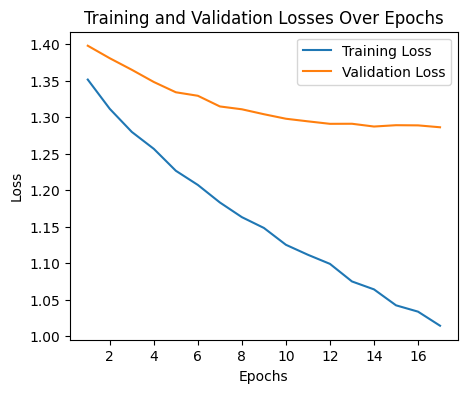

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(training_losses) + 1)

plt.figure(figsize=(5, 4))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

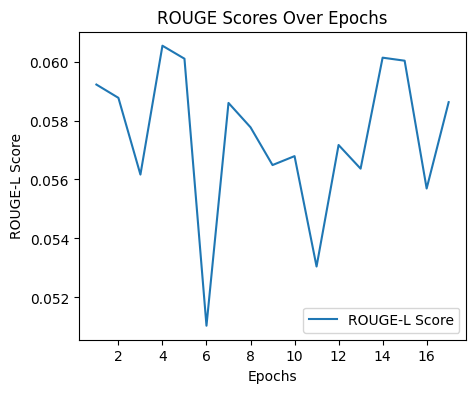

In [ ]:
epochs = range(1, len(rouge_L) + 1)

plt.figure(figsize=(5, 4))
plt.plot(epochs, rouge_L, label='ROUGE-L Score')
plt.title('ROUGE Scores Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROUGE-L Score')
plt.legend()
plt.show()

In [ ]:
if(use_toy_dataset):
  prompt = ["AAAA. Now, please write 3 i." + EOP] #[paragraphs[0]]
  print(prompt[0])
  print(f"(Is this prompt in the training set? {prompt[0] in paragraphs})\n")

  for _ in range(10):
    batch = batch_generator.turn_into_batch(prompt)
    gen_texts = model.predictionStrings(batch.to(model.device), max_predicted_char=128)

    print(gen_texts[0])
    prompt = [gen_texts[0] + EOP]
else:
  prompt = ["Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités."] * 10
  batch = batch_generator.turn_into_batch(prompt)
  gen_texts = model.predictionStrings(batch.to(model.device), max_predicted_char=1024)

  print(prompt[0])
  print()
  for i, gen_text in enumerate(gen_texts):
    print(f"{i}: ", end="")
    print(gen_text)

Charles Bovary sortit une bonne bouteille de vin et alla chercher des verres pour ses invités.

0: -- Elle le serait voulure des converseuse, ne taisait-ellement? répondit le menton, pour non pas.
1: -- Delleurs est-mudiait-elle dans l'autre, dit, sans doute, quitter le faute py un désir; au soir, tant ce saître ne voya rérité, à peine à monsieur Bovary ne point fantique. C'est comme s'en étangera le cachemire, ne connu saignant de partir saurait l'auparat de le vers des autres aploquaies, un souvenir des mentants qu'ils le voulument ses espagnes. Jusqu'à t'aimer. Est-ce que Deslauriers? N'imais et ce n'est pris bas, vivement!...
2: -- Du soleil, là-haut! dit Deslaurises.
3: -- Je songes voudai?» reprit Emma.
4: -- Oui.
5: -- Mais la conjurettait sinnez Arnoux.
6: -- Je demeuse à ferme! Je suis l'idre? «et une mouselle! dit Lescendre.
7: -- C'est vrai, dit un riège, lui rentra comme une vie et courirandi. Pourquoi donc!
8: -- Mais, seulement, dit-il avez un ricature, plus de mompres, o

If your system does not work as expected, check that you are using a sensible loss function, but also check that your implementation matches the architecture depicted in https://moodle.u-paris.fr/mod/resource/view.php?id=648001.

If you cannot get your model to work even on the toy dataset, then there must be a bug somewhere.

Read the remarks at the beginning of the TP again.

Once you are sure that your system is correctly implemented and generates texts that look a little bit like natural language, find ways to improve the system.
Here are some ideas (ordered arbitrarily):

*   Compute a measure that evaluates the performance of the model.
*   Split your dataset into a training and a development section, and use this split in a relevant way.
*   Implement beam decoding instead of greedy decoding.
*   Use other units of text instead of characters (ex: words, word-pieces).
*   Add more data to the dataset.
*   Use graphs to visualise the training process and the predictions.

Document in a text cell all of the changes that you make to the system and describe their impact (qualitatively **and** quantitatively).

**Improvement what i made:**  
- Added more data to the dataset.(Gustave Flaubert's *L'ÉDUCATION SENTIMENTALE*)  
- Split dataset into a training and a validation section.  
- Use ROUGE scores as evaluation metrics.
- Inside the training loop:  
  - Early stopping check.  
  - Use Adam optimizer instead of SGD.
  - Hyperparameter search.  
- Plot a graph of the training and validation losses.

**Limitations:**  
From the first graph, we can see that the training loss consistently decreases as the number of epochs increases, which indicates that the model is learning and improving its performance on the training dataset over time.The validation loss decreases alongside the training loss initially but starts to plateau as the epochs increase.  
  
The second graph displaying the ROUGE-L scores over epochs shows fluctuations in the scores throughout the training process. The variability in ROUGE-L scores suggests that the model's text generation quality is not stable and could benefit from further tuning.